In [57]:
from utils.BackTest import Engine, Strategy
import pandas as pd
import xgboost as xgb
import numpy as np
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import optuna
import optuna.visualization as vis
import os
import matplotlib.pyplot as plt

In [58]:
df = pd.read_csv(r'../data/processed/merged_df_with_signals.csv')

In [59]:
df

,datetime,reddit_smoothed_sentiment_weibull_week,news_smoothed_sentiment_weibull_week,tele_smoothed_sentiment_weibull_week,Open,High,Low,Close,TOTAL_TRADES,TOTAL_TRADES_BUY,...,reddit_sentiment_log,news_sentiment_log,tele_sentiment_log,reddit_Signal,news_Signal,tele_Signal,typical_price,DATE,VWAP,VWAP_Signal
0,2024-01-27 13:00:00,0.000000,-857.923901,6.872941,41750.00,41806.55,41725.21,41742.44,35569,10171,...,0.000000,-6.755482,2.060767,0.0,-1.0,1.0,41758.066667,2024-01-27,41758.066667,-1
1,2024-01-27 14:00:00,0.027001,-867.694664,6.872941,41742.44,41818.39,41731.01,41766.00,27238,12281,...,0.026643,-6.766796,2.060767,1.0,-1.0,1.0,41771.800000,2024-01-27,41765.490372,1
2,2024-01-27 15:00:00,0.164191,-875.992357,6.872941,41766.00,41894.87,41733.60,41814.00,32410,14004,...,0.152026,-6.776304,2.060767,1.0,-1.0,1.0,41814.156667,2024-01-27,41784.423590,1
3,2024-01-27 16:00:00,0.300527,-882.407146,6.892280,41814.00,41895.74,41791.22,41810.18,30278,13664,...,0.262769,-6.783594,2.063227,1.0,-1.0,1.0,41832.380000,2024-01-27,41798.313570,1
4,2024-01-27 17:00:00,0.435303,-886.430380,6.892280,41810.18,41845.34,41774.07,41779.28,24681,9330,...,0.361376,-6.788139,2.063227,1.0,-1.0,1.0,41799.563333,2024-01-27,41798.533122,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10171,2025-03-26 08:00:00,-0.487101,-43.013907,12.500145,88140.45,88200.00,87886.10,87959.73,59816,30655,...,-0.396829,-3.780636,2.601147,-1.0,-1.0,1.0,88015.276667,2025-03-26,87642.510178,1
10172,2025-03-26 09:00:00,-0.456887,-39.331997,12.500145,87959.73,88056.61,87837.49,87939.99,43067,23857,...,-0.376302,-3.692921,2.601147,-1.0,-1.0,1.0,87944.696667,2025-03-26,87661.828105,1
10173,2025-03-26 10:00:00,-0.427685,-37.038648,12.500145,87939.99,88259.81,87939.99,88208.47,55584,29793,...,-0.356054,-3.634124,2.601147,-1.0,-1.0,1.0,88136.090000,2025-03-26,87701.167882,1
10174,2025-03-26 11:00:00,-0.399548,-37.530942,12.500145,88208.47,88242.00,87923.91,87954.96,67105,30529,...,-0.336149,-3.647040,2.601147,-1.0,-1.0,1.0,88040.290000,2025-03-26,87742.875495,1


In [60]:
base_price_data = ['datetime','Close','Open','High','Low','VOLUME']

technical_indicators = [
    # Trend Indicators
    'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
    'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',

    # Momentum Indicators
    'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
    'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
    '%K', '%D', 'Stochastic_Signal',

    # Volatility Indicators
    'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',

    # Volume-Based Indicators
    'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
]

sentiment_indicators = [
    'reddit_sentiment_log',
    'tele_sentiment_log',
    'news_sentiment_log',
]

# Create a new DataFrame with the selected columns
selected_columns = base_price_data + technical_indicators + sentiment_indicators
df_selected = df[selected_columns]

In [61]:
working_frame = df_selected.copy().set_index(pd.to_datetime(df_selected['datetime'])).drop(columns=['datetime'])
working_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-27 13:00:00,41742.44,41750.00,41806.55,41725.21,419.38468,41729.550796,41714.525206,41617.761701,1,41720.541302,...,41524.488454,175.710000,81.34,-419.38468,-65.712408,0,-1,0.000000,2.060767,-6.755482
2024-01-27 14:00:00,41766.00,41742.44,41818.39,41731.01,493.43458,41737.650619,41721.878748,41631.237910,1,41727.534948,...,41541.267296,140.500000,87.38,493.43458,-12.460314,1,1,0.026643,2.060767,-6.766796
2024-01-27 15:00:00,41814.00,41766.00,41894.87,41733.60,581.25856,41754.617148,41735.038927,41647.852645,1,41740.837263,...,41561.147977,109.318333,161.27,581.25856,44.084341,0,1,0.152026,2.060767,-6.776304
2024-01-27 16:00:00,41810.18,41814.00,41895.74,41791.22,609.18361,41766.964449,41745.773366,41662.609678,1,41751.505377,...,41571.210298,101.921667,104.52,-609.18361,-18.131655,-1,1,0.262769,2.063227,-6.783594
2024-01-27 17:00:00,41779.28,41810.18,41845.34,41774.07,448.23397,41769.701238,41750.560028,41673.216071,1,41755.778396,...,41588.600128,99.801667,71.27,-448.23397,-59.093780,0,-1,0.361376,2.063227,-6.788139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-26 08:00:00,87959.73,88140.45,88200.00,87886.10,525.11331,87756.884904,87689.841782,87613.211597,1,87700.669674,...,87158.682498,418.066667,313.90,-525.11331,59.670458,-1,1,-0.396829,2.601147,-3.780636
2025-03-26 09:00:00,87939.99,87959.73,88056.61,87837.49,393.09750,87797.574925,87725.577241,87642.918724,1,87737.488186,...,87170.539414,392.118333,219.12,-393.09750,16.549700,0,1,-0.376302,2.601147,-3.692921
2025-03-26 10:00:00,88208.47,87939.99,88259.81,87939.99,556.20541,87888.884942,87794.561921,87694.332477,1,87809.946926,...,87154.234720,378.148333,319.82,556.20541,67.945482,1,1,-0.356054,2.601147,-3.634124


In [62]:
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('xgboost_model.json')

In [63]:
loaded_final_model = xgb.XGBRegressor()
loaded_final_model.load_model('xgboost_model_final.json')

In [64]:
labels = pd.read_parquet(f'../data/processed/labels_btc.parquet')
inputs = np.load(f'../data/processed/inputs_btc.npy')

In [121]:
class XGBoostStrategy(Strategy):
    def __init__(self,model,bet_size = 0.1,initial_data=None):
        super().__init__()
        self.model = model 
        self.initial_data = initial_data
        self.bet_size = bet_size  # 10% of cash

    def on_bar(self):

        temp_df = pd.concat([self.initial_data, self.data])

        features = self.sequencing_data(temp_df, window_size=6)

        # ###TESTING INPUTS###
        # print("Current index:", self.current_idx)

        # idx = labels[labels['inference_date'] == self.current_idx].index
        # arr = inputs[idx]
        # are_close = np.allclose(arr, features, atol=1e-5)

        # print("Arrays are close:", are_close)

        # if self.current_idx == pd.to_datetime('2025-02-28 00:00:00'):
        #     print(features)

        predictions = self.model.predict(features)
        signal = self.determine_signal(predictions)
        if signal == 1:
            self.buy(
                "btc",
               size = round(self.bet_size * (self.cash) / self.close(), 8)
            )
        elif signal == -1:
            self.sell(
                "btc",
                size = round( self.bet_size * (self.cash) / self.close(), 8)
            )
        else:
            pass

    def determine_signal(self, predictions):
        """Determine buy/sell/hold signal based on predictions."""
        future_forecasts = predictions.flatten().tolist()  # Convert to list if needed
        close = self.close()

        above_close = sum(forecast > close for forecast in future_forecasts)
        below_close = sum(forecast < close for forecast in future_forecasts)

        if above_close >= 3:
            return 1  # Buy
        elif below_close >= 3:
            return -1  # Sell
        else:
           return 0  # Hold
        
    def sequencing_data(self, df, window_size=6):
        start_time = self.current_idx - pd.Timedelta(hours=window_size)
        past_data = df.loc[start_time:self.current_idx]

        # Collect past feature lists
        past_features = [
            past_data['Close'].tolist(),
            past_data['High'].tolist(),
            past_data['Low'].tolist(),
            past_data['VOLUME'].tolist()
        ]

        # Technical Indicators
        indicators = [
            'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
            'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',
            'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
            'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
            '%K', '%D', 'Stochastic_Signal',
            'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',
            'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
        ]
        
        for indicator in indicators:
            past_features.append(past_data[indicator].tolist())

        # Sentiment indicators
        sentiments = ['reddit_sentiment_log', 'tele_sentiment_log', 'news_sentiment_log']
        
        for sentiment in sentiments:
            past_features.append(past_data[sentiment].tolist())

        # Convert to 1D NumPy array and reshape to (1, 252)
        past_features_array = np.concatenate(past_features).reshape(1, -1)
        
        return past_features_array  # Shape: (1, 252)

In [95]:
initial_val_frame = working_frame[(working_frame.index >= pd.to_datetime('2025-01-01') - pd.Timedelta(hours=6)) & (working_frame.index < '2025-01-01')]
validate_frame = working_frame[(working_frame.index >= '2025-01-01') & (working_frame.index < '2025-03-01')]

initial_test_frame = working_frame[(working_frame.index >= pd.to_datetime('2025-03-01') - pd.Timedelta(hours=6)) & (working_frame.index < '2025-03-01')]
test_frame = working_frame[working_frame.index >= '2025-03-01']

In [96]:
validate_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,94401.14,93576.00,94509.42,93489.03,755.99010,94011.893818,94029.638251,93958.906655,0,94032.973503,...,92381.690536,622.563333,1020.39,755.99010,103.811170,0,1,0.450214,2.029984,-6.587146
2025-01-01 01:00:00,93607.74,94401.14,94408.72,93578.77,586.53456,93922.081858,93969.367072,93926.982413,-1,93967.552964,...,92563.555167,664.478333,829.95,-586.53456,38.063957,-1,-1,0.375333,2.029984,-6.607708
2025-01-01 02:00:00,94098.91,93607.74,94105.12,93594.56,276.78045,93961.377001,93987.873205,93942.612194,0,93987.761739,...,92755.139100,620.850000,510.56,276.78045,60.798861,1,1,0.295866,2.029984,-6.627062
2025-01-01 03:00:00,93838.04,94098.91,94098.91,93728.22,220.99302,93933.968779,93966.468461,93933.105631,0,93964.727625,...,92934.645329,606.051667,370.69,-220.99302,33.961539,-1,-1,0.211558,2.029984,-6.644706
2025-01-01 04:00:00,93553.91,93838.04,93838.04,93500.00,279.46909,93849.511272,93907.531538,93898.633301,-1,93901.524914,...,92885.780670,575.041667,338.04,-279.46909,4.111003,0,-1,0.122122,2.029984,-6.659001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 19:00:00,84449.99,84440.97,84810.35,84209.84,1656.89446,83302.202137,82785.136766,82669.910295,1,82850.241395,...,77705.107174,1456.295000,600.51,1656.89446,484.835909,0,1,-1.221349,0.913890,-8.396762
2025-02-28 20:00:00,84191.27,84449.99,84795.03,83600.00,2215.50549,83499.772773,82986.012942,82808.215723,1,83056.553488,...,77711.558133,1409.260000,1195.03,-2215.50549,227.660538,-1,1,-1.246760,0.913890,-8.393514
2025-02-28 21:00:00,84258.37,84191.27,84596.00,84000.17,862.30163,83668.349935,83167.778236,82940.047930,1,83241.448336,...,77655.745657,1103.960000,595.83,862.30163,288.102547,1,1,-1.269582,0.919505,-8.389415


In [97]:
initial_val_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-31 18:00:00,93875.68,94120.94,94416.72,93779.80,816.81017,94452.342269,94276.150021,94036.116190,1,94314.297882,...,91418.780827,1160.111667,636.92,-816.81017,43.134507,0,-1,0.644116,1.968432,-6.413587
2024-12-31 19:00:00,94166.88,93875.68,94290.91,93712.45,462.79342,94388.906209,94260.540018,94048.003809,1,94291.618208,...,91518.783895,1001.461667,578.46,462.79342,83.102023,1,1,0.618698,2.029984,-6.449630
2024-12-31 20:00:00,93564.04,94166.88,94222.50,93450.17,733.04147,94205.602607,94161.040016,94004.007099,1,94179.683099,...,91657.553926,983.908333,772.33,-733.04147,5.374071,-1,-1,0.592473,2.029984,-6.482636
2024-12-31 21:00:00,93899.68,93564.04,93964.15,93504.67,337.52715,94137.619805,94123.702871,93994.522817,1,94136.605699,...,91830.596274,881.571667,459.48,337.52715,37.007698,1,-1,0.565590,2.029984,-6.514657
2024-12-31 22:00:00,93488.84,93899.68,93899.68,93375.58,315.53272,93993.446515,94033.008175,93948.551652,0,94036.949438,...,91979.914579,804.901667,524.10,-315.53272,3.432420,-1,-1,0.538200,2.029984,-6.543260
2024-12-31 23:00:00,93576.00,93488.84,93756.00,93375.38,336.57995,93900.680623,93967.721293,93914.683320,-1,93966.034140,...,92141.877951,558.651667,380.62,336.57995,35.160756,1,-1,0.510451,2.029984,-6.566459


In [98]:
# Store all trials' results
all_trials = []

def objective(trial):
    # Optimize bet size between 1% and 50% of capital
    bet_size = trial.suggest_float("bet_size", 0.01, 0.5)  

    # Run backtest with the given bet size
    e = Engine()
    e.add_data(validate_frame)
    e.add_strategy(XGBoostStrategy(model=loaded_model, bet_size=bet_size,initial_data= initial_val_frame))  # Pass optimized bet size

    stats = e.run()

    # Save trial results
    trial_result = {
        "trial": trial.number,
        "sharpe": stats.get("Strategy Sharpe Ratio", np.nan),
        "return": stats.get("Total Return (%)", np.nan),
        "drawdown": stats.get("Strategy Max Drawdown (%)", np.nan),
        "bet_size": bet_size,
    }
    all_trials.append(trial_result)

    return trial_result["sharpe"]  # Optimize for Sharpe Ratio

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Save results
results_df = pd.DataFrame(all_trials)

print("Best Sharpe:", study.best_value)
print("Best Bet Size:", study.best_params["bet_size"])


[I 2025-04-03 22:19:46,871] A new study created in memory with name: no-name-33b6d5cf-78e1-4f1d-bff9-42865542269d
100%|██████████| 1416/1416 [00:03<00:00, 467.73it/s]
[I 2025-04-03 22:19:49,918] Trial 0 finished with value: 1.0570075989263645 and parameters: {'bet_size': 0.04356631285357605}. Best is trial 0 with value: 1.0570075989263645.


Final Portfolio Value: 103044.93256177442
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.04
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -125.87
Strategy CAGR (%)                        |      13.92
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.17
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.06
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -22.25
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     848.00
Number of Buys                           |     434.00
Number of Sells                          |     414.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 445.13it/s]
[I 2025-04-03 22:19:53,116] Trial 1 finished with value: -0.77045933930136 and parameters: {'bet_size': 0.15906700210941122}. Best is trial 0 with value: 1.0570075989263645.


Final Portfolio Value: 97856.89213794134
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.14
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -84.54
Strategy CAGR (%)                        |      -8.98
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.66
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.77
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.15
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     627.00
Number of Buys                           |     312.00
Number of Sells                          |     315.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 446.15it/s]
[I 2025-04-03 22:19:56,311] Trial 2 finished with value: -0.28036562779177665 and parameters: {'bet_size': 0.05876037667821051}. Best is trial 0 with value: 1.0570075989263645.


Final Portfolio Value: 99157.78084655531
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.84
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -111.86
Strategy CAGR (%)                        |      -3.61
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.87
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.28
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.60
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     803.00
Number of Buys                           |     409.00
Number of Sells                          |     394.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 446.95it/s]
[I 2025-04-03 22:19:59,501] Trial 3 finished with value: -0.3243035924282812 and parameters: {'bet_size': 0.09098525577464714}. Best is trial 0 with value: 1.0570075989263645.


Final Portfolio Value: 99100.14689973867
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.90
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -90.70
Strategy CAGR (%)                        |      -3.85
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.88
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.32
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.65
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     740.00
Number of Buys                           |     373.00
Number of Sells                          |     367.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 460.88it/s]
[I 2025-04-03 22:20:02,593] Trial 4 finished with value: -0.8802328938247117 and parameters: {'bet_size': 0.4625886558613874}. Best is trial 0 with value: 1.0570075989263645.


Final Portfolio Value: 97589.53669084098
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.41
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -78.58
Strategy CAGR (%)                        |     -10.06
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.43
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.88
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.36
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     452.00
Number of Buys                           |     220.00
Number of Sells                          |     232.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 453.86it/s]
[I 2025-04-03 22:20:05,827] Trial 5 finished with value: -1.0343843574871499 and parameters: {'bet_size': 0.447312827548289}. Best is trial 0 with value: 1.0570075989263645.


Final Portfolio Value: 97235.97573966674
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.76
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -75.87
Strategy CAGR (%)                        |     -11.47
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.08
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.03
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.84
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     454.00
Number of Buys                           |     221.00
Number of Sells                          |     233.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 454.14it/s]
[I 2025-04-03 22:20:08,964] Trial 6 finished with value: -1.1136184701966128 and parameters: {'bet_size': 0.22674434537155588}. Best is trial 0 with value: 1.0570075989263645.


Final Portfolio Value: 96912.28318278515
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.09
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -78.61
Strategy CAGR (%)                        |     -12.74
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.44
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.11
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.18
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     563.00
Number of Buys                           |     279.00
Number of Sells                          |     284.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 408.53it/s]
[I 2025-04-03 22:20:12,445] Trial 7 finished with value: -1.0325187894382524 and parameters: {'bet_size': 0.456194349672226}. Best is trial 0 with value: 1.0570075989263645.


Final Portfolio Value: 97181.09518913305
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.82
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -77.40
Strategy CAGR (%)                        |     -11.68
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.31
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.03
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.19
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     454.00
Number of Buys                           |     221.00
Number of Sells                          |     233.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 407.38it/s]
[I 2025-04-03 22:20:15,941] Trial 8 finished with value: -1.3018702249074563 and parameters: {'bet_size': 0.17164811385777184}. Best is trial 0 with value: 1.0570075989263645.


Final Portfolio Value: 96269.42773344876
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.73
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -82.16
Strategy CAGR (%)                        |     -15.23
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.70
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.30
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.82
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     613.00
Number of Buys                           |     304.00
Number of Sells                          |     309.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 356.67it/s]
[I 2025-04-03 22:20:19,935] Trial 9 finished with value: -2.031697498443344 and parameters: {'bet_size': 0.33677574742203514}. Best is trial 0 with value: 1.0570075989263645.


Final Portfolio Value: 94453.11084664585
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -5.55
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -75.08
Strategy CAGR (%)                        |     -21.96
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.81
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -2.03
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.90
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     498.00
Number of Buys                           |     245.00
Number of Sells                          |     253.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 358.66it/s]
[I 2025-04-03 22:20:23,911] Trial 10 finished with value: 12.077312485210129 and parameters: {'bet_size': 0.013305085889340273}. Best is trial 10 with value: 12.077312485210129.


Final Portfolio Value: 125160.25858440217
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      25.16
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -143.85
Strategy CAGR (%)                        |     165.14
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.67
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      12.08
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.63
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1006.00
Number of Buys                           |     483.00
Number of Sells                          |     523.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 380.01it/s]
[I 2025-04-03 22:20:27,663] Trial 11 finished with value: 3.051159217820658 and parameters: {'bet_size': 0.03278421174419607}. Best is trial 10 with value: 12.077312485210129.


Final Portfolio Value: 108380.90504617183
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       8.38
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -139.46
Strategy CAGR (%)                        |      41.86
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.72
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.05
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -24.37
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     886.00
Number of Buys                           |     457.00
Number of Sells                          |     429.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 380.81it/s]
[I 2025-04-03 22:20:31,412] Trial 12 finished with value: 2.6922598588335664 and parameters: {'bet_size': 0.03403437632205264}. Best is trial 10 with value: 12.077312485210129.


Final Portfolio Value: 107460.39599117356
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.46
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -137.66
Strategy CAGR (%)                        |      36.70
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.63
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.69
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -24.22
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     880.00
Number of Buys                           |     454.00
Number of Sells                          |     426.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 389.48it/s]
[I 2025-04-03 22:20:35,079] Trial 13 finished with value: -1.1319689414379699 and parameters: {'bet_size': 0.12533768128975128}. Best is trial 10 with value: 12.077312485210129.


Final Portfolio Value: 96737.75427854041
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.26
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -85.00
Strategy CAGR (%)                        |     -13.42
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.86
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.13
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.53
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     675.00
Number of Buys                           |     338.00
Number of Sells                          |     337.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 363.37it/s]
[I 2025-04-03 22:20:38,998] Trial 14 finished with value: 10.656957162237374 and parameters: {'bet_size': 0.014867636956501118}. Best is trial 10 with value: 12.077312485210129.


Final Portfolio Value: 123254.17277639123
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      23.25
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -146.66
Strategy CAGR (%)                        |     148.04
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.89
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      10.66
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -22.22
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     989.00
Number of Buys                           |     483.00
Number of Sells                          |     506.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 365.38it/s]
[I 2025-04-03 22:20:42,899] Trial 15 finished with value: -0.28497337055973554 and parameters: {'bet_size': 0.31660425288295857}. Best is trial 10 with value: 12.077312485210129.


Final Portfolio Value: 99255.79020553049
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.74
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -78.77
Strategy CAGR (%)                        |      -3.19
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.21
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.28
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.52
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     521.00
Number of Buys                           |     257.00
Number of Sells                          |     264.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 355.61it/s]
[I 2025-04-03 22:20:46,917] Trial 16 finished with value: -1.1600444598381323 and parameters: {'bet_size': 0.2183348910964021}. Best is trial 10 with value: 12.077312485210129.


Final Portfolio Value: 96758.9999747019
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.24
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -85.28
Strategy CAGR (%)                        |     -13.34
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.50
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.16
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.17
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     573.00
Number of Buys                           |     284.00
Number of Sells                          |     289.00
Win Rate (%)        

100%|██████████| 1416/1416 [00:04<00:00, 344.62it/s]
[I 2025-04-03 22:20:51,069] Trial 17 finished with value: 13.507871586043217 and parameters: {'bet_size': 0.012220526526213664}. Best is trial 17 with value: 13.507871586043217.


Final Portfolio Value: 126704.76633141305
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      26.70
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -141.54
Strategy CAGR (%)                        |     179.65
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.30
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      13.51
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.07
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1021.00
Number of Buys                           |     483.00
Number of Sells                          |     538.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:04<00:00, 351.67it/s]
[I 2025-04-03 22:20:55,125] Trial 18 finished with value: -0.8779939897565944 and parameters: {'bet_size': 0.10406501249280935}. Best is trial 17 with value: 13.507871586043217.


Final Portfolio Value: 97487.08153749812
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.51
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -84.46
Strategy CAGR (%)                        |     -10.47
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.92
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.88
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.16
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     712.00
Number of Buys                           |     358.00
Number of Sells                          |     354.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 366.06it/s]
[I 2025-04-03 22:20:59,015] Trial 19 finished with value: -1.501972402600119 and parameters: {'bet_size': 0.33504258573595214}. Best is trial 17 with value: 13.507871586043217.


Final Portfolio Value: 96008.71246104414
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.99
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -75.39
Strategy CAGR (%)                        |     -16.22
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.80
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.50
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.55
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     501.00
Number of Buys                           |     247.00
Number of Sells                          |     254.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 362.30it/s]
[I 2025-04-03 22:21:02,947] Trial 20 finished with value: -0.7707352293997375 and parameters: {'bet_size': 0.1581230800231946}. Best is trial 17 with value: 13.507871586043217.


Final Portfolio Value: 97869.60961460939
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.13
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -84.04
Strategy CAGR (%)                        |      -8.93
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.59
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.77
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.05
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     627.00
Number of Buys                           |     312.00
Number of Sells                          |     315.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 380.09it/s]
[I 2025-04-03 22:21:06,694] Trial 21 finished with value: -0.6723922090079372 and parameters: {'bet_size': 0.07445990313940357}. Best is trial 17 with value: 13.507871586043217.


Final Portfolio Value: 98006.15074215275
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.99
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -102.35
Strategy CAGR (%)                        |      -8.38
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.46
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.67
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.93
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     770.00
Number of Buys                           |     391.00
Number of Sells                          |     379.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 376.04it/s]
[I 2025-04-03 22:21:10,485] Trial 22 finished with value: 9.208435616159305 and parameters: {'bet_size': 0.016793351245860445}. Best is trial 17 with value: 13.507871586043217.


Final Portfolio Value: 121021.63694494174
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      21.02
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -148.61
Strategy CAGR (%)                        |     129.10
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.02
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       9.21
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.83
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     972.00
Number of Buys                           |     483.00
Number of Sells                          |     489.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 390.07it/s]
[I 2025-04-03 22:21:14,133] Trial 23 finished with value: 16.26628207676062 and parameters: {'bet_size': 0.010266043384571405}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 128906.83916336703
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.91
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -135.46
Strategy CAGR (%)                        |     201.39
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.38
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      16.27
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.20
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1054.00
Number of Buys                           |     483.00
Number of Sells                          |     571.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 397.68it/s]
[I 2025-04-03 22:21:17,719] Trial 24 finished with value: -1.4096016539532517 and parameters: {'bet_size': 0.11929141126478826}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 95822.42993929236
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -4.18
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -85.43
Strategy CAGR (%)                        |     -16.92
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.01
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.41
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.36
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     680.00
Number of Buys                           |     341.00
Number of Sells                          |     339.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 391.16it/s]
[I 2025-04-03 22:21:21,358] Trial 25 finished with value: -0.6032622773941292 and parameters: {'bet_size': 0.0725439371360446}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 98227.09874692497
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.77
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -101.46
Strategy CAGR (%)                        |      -7.48
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.40
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.60
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.72
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     773.00
Number of Buys                           |     392.00
Number of Sells                          |     381.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 386.91it/s]
[I 2025-04-03 22:21:25,052] Trial 26 finished with value: 0.37843558260880733 and parameters: {'bet_size': 0.39885399002530053}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 100914.89468072087
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.91
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -82.16
Strategy CAGR (%)                        |       4.04
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.67
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.38
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.09
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     473.00
Number of Buys                           |     232.00
Number of Sells                          |     241.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 391.95it/s]
[I 2025-04-03 22:21:28,704] Trial 27 finished with value: 14.92152187988155 and parameters: {'bet_size': 0.0111773898922156}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 127900.49553738622
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      27.90
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -138.54
Strategy CAGR (%)                        |     191.30
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.82
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      14.92
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.54
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1037.00
Number of Buys                           |     483.00
Number of Sells                          |     554.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 404.64it/s]
[I 2025-04-03 22:21:32,234] Trial 28 finished with value: -0.43496886633440307 and parameters: {'bet_size': 0.292292451061719}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 98897.53352681382
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.10
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -74.25
Strategy CAGR (%)                        |      -4.70
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.81
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.43
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.14
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     521.00
Number of Buys                           |     257.00
Number of Sells                          |     264.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 378.02it/s]
[I 2025-04-03 22:21:36,014] Trial 29 finished with value: -0.28828751399906827 and parameters: {'bet_size': 0.061810909498425784}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 99141.91042878765
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.86
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -109.47
Strategy CAGR (%)                        |      -3.68
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.75
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.29
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.47
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     796.00
Number of Buys                           |     405.00
Number of Sells                          |     391.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 383.45it/s]
[I 2025-04-03 22:21:39,727] Trial 30 finished with value: -1.4720281620604259 and parameters: {'bet_size': 0.13151976568609053}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 95591.5188465324
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -4.41
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -85.61
Strategy CAGR (%)                        |     -17.79
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.09
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.47
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.27
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     665.00
Number of Buys                           |     333.00
Number of Sells                          |     332.00
Win Rate (%)        

100%|██████████| 1416/1416 [00:03<00:00, 398.33it/s]
[I 2025-04-03 22:21:43,307] Trial 31 finished with value: 0.3694026217188646 and parameters: {'bet_size': 0.05158885334805893}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 101083.32455586903
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.08
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -116.53
Strategy CAGR (%)                        |       4.79
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.97
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.37
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -21.02
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     831.00
Number of Buys                           |     424.00
Number of Sells                          |     407.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 396.04it/s]
[I 2025-04-03 22:21:46,910] Trial 32 finished with value: 15.518584110934976 and parameters: {'bet_size': 0.010826129227370439}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 128449.53256671333
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.45
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -137.68
Strategy CAGR (%)                        |     196.77
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.68
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.52
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.03
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1044.00
Number of Buys                           |     483.00
Number of Sells                          |     561.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 377.02it/s]
[I 2025-04-03 22:21:50,699] Trial 33 finished with value: 0.7658923108003405 and parameters: {'bet_size': 0.04725156584412319}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 102203.60385599153
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.20
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -121.13
Strategy CAGR (%)                        |       9.93
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.97
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.77
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -21.55
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     839.00
Number of Buys                           |     429.00
Number of Sells                          |     410.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 416.13it/s]
[I 2025-04-03 22:21:54,127] Trial 34 finished with value: -0.20611790100533894 and parameters: {'bet_size': 0.08633652444808307}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 99433.96459468751
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.57
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -89.55
Strategy CAGR (%)                        |      -2.44
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.82
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.21
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.24
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     751.00
Number of Buys                           |     378.00
Number of Sells                          |     373.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 396.73it/s]
[I 2025-04-03 22:21:57,715] Trial 35 finished with value: -1.436519862169144 and parameters: {'bet_size': 0.17760275525749872}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 95862.68139072004
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -4.14
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -83.84
Strategy CAGR (%)                        |     -16.77
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.68
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.44
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.64
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     611.00
Number of Buys                           |     303.00
Number of Sells                          |     308.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 400.10it/s]
[I 2025-04-03 22:22:01,279] Trial 36 finished with value: 15.881914319911052 and parameters: {'bet_size': 0.010514157170564507}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 128654.80076994808
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.65
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -136.50
Strategy CAGR (%)                        |     198.84
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.52
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.88
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.57
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1049.00
Number of Buys                           |     483.00
Number of Sells                          |     566.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 366.36it/s]
[I 2025-04-03 22:22:05,164] Trial 37 finished with value: -0.9057162813202876 and parameters: {'bet_size': 0.09707659572816117}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 97386.71970061479
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.61
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -88.08
Strategy CAGR (%)                        |     -10.87
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.00
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.91
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.56
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     722.00
Number of Buys                           |     363.00
Number of Sells                          |     359.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 404.38it/s]
[I 2025-04-03 22:22:08,686] Trial 38 finished with value: 0.2768336551182998 and parameters: {'bet_size': 0.055485257437536475}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 100803.72071625742
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.80
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -113.09
Strategy CAGR (%)                        |       3.54
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.78
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.28
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.04
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     818.00
Number of Buys                           |     416.00
Number of Sells                          |     402.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 386.99it/s]
[I 2025-04-03 22:22:12,377] Trial 39 finished with value: -1.0618840446188973 and parameters: {'bet_size': 0.14445088292871702}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 96995.2972484153
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.00
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -82.83
Strategy CAGR (%)                        |     -12.41
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.69
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.06
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.01
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     646.00
Number of Buys                           |     323.00
Number of Sells                          |     323.00
Win Rate (%)        

100%|██████████| 1416/1416 [00:03<00:00, 394.57it/s]
[I 2025-04-03 22:22:15,990] Trial 40 finished with value: -1.2714034493304693 and parameters: {'bet_size': 0.2000806405071434}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 96418.1854443054
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.58
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -79.69
Strategy CAGR (%)                        |     -14.66
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.53
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.27
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.62
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     591.00
Number of Buys                           |     292.00
Number of Sells                          |     299.00
Win Rate (%)        

100%|██████████| 1416/1416 [00:03<00:00, 378.31it/s]
[I 2025-04-03 22:22:19,754] Trial 41 finished with value: 12.176645692440951 and parameters: {'bet_size': 0.013265368933485115}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 125296.25832506732
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      25.30
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -143.80
Strategy CAGR (%)                        |     166.39
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.66
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      12.18
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.58
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1007.00
Number of Buys                           |     483.00
Number of Sells                          |     524.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 389.94it/s]
[I 2025-04-03 22:22:23,404] Trial 42 finished with value: 2.4740799924233854 and parameters: {'bet_size': 0.035859688192134906}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 106897.75320990747
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.90
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -135.76
Strategy CAGR (%)                        |      33.62
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.59
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.47
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.94
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     873.00
Number of Buys                           |     449.00
Number of Sells                          |     424.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 357.53it/s]
[I 2025-04-03 22:22:27,387] Trial 43 finished with value: -0.20873695332394934 and parameters: {'bet_size': 0.4923708545962058}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 99454.93047774446
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -79.55
Strategy CAGR (%)                        |      -2.35
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.24
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.21
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.66
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     443.00
Number of Buys                           |     216.00
Number of Sells                          |     227.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 394.36it/s]
[I 2025-04-03 22:22:31,001] Trial 44 finished with value: 2.7012001512100157 and parameters: {'bet_size': 0.034959166452099164}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 107440.61437858568
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.44
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -136.08
Strategy CAGR (%)                        |      36.59
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.55
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.70
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.89
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     878.00
Number of Buys                           |     452.00
Number of Sells                          |     426.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:04<00:00, 349.98it/s]
[I 2025-04-03 22:22:35,064] Trial 45 finished with value: -0.49017781219691553 and parameters: {'bet_size': 0.07785997618271054}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 98591.718596286
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.41
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -96.33
Strategy CAGR (%)                        |      -5.98
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.19
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.49
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.21
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     764.00
Number of Buys                           |     385.00
Number of Sells                          |     379.00
Win Rate (%)         

100%|██████████| 1416/1416 [00:03<00:00, 387.14it/s]
[I 2025-04-03 22:22:38,749] Trial 46 finished with value: -1.1158519875139197 and parameters: {'bet_size': 0.10337999324387018}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 96735.04887072425
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.26
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -85.24
Strategy CAGR (%)                        |     -13.43
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.04
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.12
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.54
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     712.00
Number of Buys                           |     358.00
Number of Sells                          |     354.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 398.16it/s]
[I 2025-04-03 22:22:42,329] Trial 47 finished with value: 15.890460608101248 and parameters: {'bet_size': 0.0105182139719886}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 128669.67171361184
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.67
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -136.50
Strategy CAGR (%)                        |     198.99
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.52
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.89
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.57
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1049.00
Number of Buys                           |     483.00
Number of Sells                          |     566.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 386.01it/s]
[I 2025-04-03 22:22:46,030] Trial 48 finished with value: -1.341912100804566 and parameters: {'bet_size': 0.2663256195103503}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 96256.84455859993
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.74
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -80.78
Strategy CAGR (%)                        |     -15.27
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.38
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.34
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.35
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     538.00
Number of Buys                           |     266.00
Number of Sells                          |     272.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 379.06it/s]
[I 2025-04-03 22:22:49,795] Trial 49 finished with value: 2.577950275754969 and parameters: {'bet_size': 0.0355405703282652}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 107117.57860108552
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.12
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -135.43
Strategy CAGR (%)                        |      34.82
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.51
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.58
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.77
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     875.00
Number of Buys                           |     450.00
Number of Sells                          |     425.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 411.04it/s]
[I 2025-04-03 22:22:53,259] Trial 50 finished with value: -0.3500587041554229 and parameters: {'bet_size': 0.40319775118537704}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 99173.28871630892
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.83
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -72.56
Strategy CAGR (%)                        |      -3.54
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.12
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.35
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.10
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     456.00
Number of Buys                           |     223.00
Number of Sells                          |     233.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 389.47it/s]
[I 2025-04-03 22:22:56,910] Trial 51 finished with value: 15.819012684389557 and parameters: {'bet_size': 0.010582504257077699}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 128631.04218096416
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.63
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -136.74
Strategy CAGR (%)                        |     198.60
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.55
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.82
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.67
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1048.00
Number of Buys                           |     483.00
Number of Sells                          |     565.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 398.38it/s]
[I 2025-04-03 22:23:00,485] Trial 52 finished with value: 3.7306315903565386 and parameters: {'bet_size': 0.02967323257068431}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 110076.83613852102
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      10.08
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -142.91
Strategy CAGR (%)                        |      51.76
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.87
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.73
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -24.88
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     902.00
Number of Buys                           |     467.00
Number of Sells                          |     435.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 386.49it/s]
[I 2025-04-03 22:23:04,165] Trial 53 finished with value: -0.5361852146736924 and parameters: {'bet_size': 0.06551876235521203}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 98401.64459662959
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.60
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -106.85
Strategy CAGR (%)                        |      -6.76
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.61
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.54
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.39
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     786.00
Number of Buys                           |     399.00
Number of Sells                          |     387.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 393.61it/s]
[I 2025-04-03 22:23:07,781] Trial 54 finished with value: 12.271206763935842 and parameters: {'bet_size': 0.013114608417178979}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 125356.15727038466
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      25.36
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -143.35
Strategy CAGR (%)                        |     166.95
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.60
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      12.27
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.36
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1008.00
Number of Buys                           |     483.00
Number of Sells                          |     525.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 394.91it/s]
[I 2025-04-03 22:23:11,399] Trial 55 finished with value: 0.5000972708777334 and parameters: {'bet_size': 0.04824353838133527}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 101457.57845409166
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -120.06
Strategy CAGR (%)                        |       6.49
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.98
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.50
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -21.50
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     837.00
Number of Buys                           |     428.00
Number of Sells                          |     409.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 390.74it/s]
[I 2025-04-03 22:23:15,048] Trial 56 finished with value: 5.264236699616733 and parameters: {'bet_size': 0.026821499299395094}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 113599.87355065499
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      13.60
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -146.65
Strategy CAGR (%)                        |      74.02
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.06
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.26
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.42
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     921.00
Number of Buys                           |     478.00
Number of Sells                          |     443.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 382.30it/s]
[I 2025-04-03 22:23:18,777] Trial 57 finished with value: 0.23377643980164192 and parameters: {'bet_size': 0.05525037293821613}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 100679.96228963815
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.68
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -112.22
Strategy CAGR (%)                        |       2.99
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.78
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.97
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     819.00
Number of Buys                           |     417.00
Number of Sells                          |     402.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 392.51it/s]
[I 2025-04-03 22:23:22,402] Trial 58 finished with value: -0.29602423242507236 and parameters: {'bet_size': 0.08287579850787788}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 99172.21034268405
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.83
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -92.73
Strategy CAGR (%)                        |      -3.55
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.98
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.30
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.52
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     756.00
Number of Buys                           |     381.00
Number of Sells                          |     375.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 395.54it/s]
[I 2025-04-03 22:23:26,006] Trial 59 finished with value: -0.9745033748959085 and parameters: {'bet_size': 0.11103738518394596}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 97214.53311985552
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.79
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -86.17
Strategy CAGR (%)                        |     -11.55
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.85
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.97
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.31
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     698.00
Number of Buys                           |     351.00
Number of Sells                          |     347.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 377.71it/s]
[I 2025-04-03 22:23:29,777] Trial 60 finished with value: 14.434027781519456 and parameters: {'bet_size': 0.011457413465576322}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 127418.6140165666
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      27.42
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -139.10
Strategy CAGR (%)                        |     186.56
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.93
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      14.43
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.95
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1032.00
Number of Buys                           |     483.00
Number of Sells                          |     549.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 374.98it/s]
[I 2025-04-03 22:23:33,582] Trial 61 finished with value: 14.733840066080885 and parameters: {'bet_size': 0.011320406605143529}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 127771.46621118623
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      27.77
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -139.10
Strategy CAGR (%)                        |     190.03
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.90
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.75
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1035.00
Number of Buys                           |     483.00
Number of Sells                          |     552.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 387.79it/s]
[I 2025-04-03 22:23:37,265] Trial 62 finished with value: 4.027225766698683 and parameters: {'bet_size': 0.028988379794473083}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 110826.60572420148
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      10.83
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -144.26
Strategy CAGR (%)                        |      56.30
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.98
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       4.03
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.24
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     907.00
Number of Buys                           |     470.00
Number of Sells                          |     437.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 390.31it/s]
[I 2025-04-03 22:23:40,918] Trial 63 finished with value: 0.5820563629987767 and parameters: {'bet_size': 0.04810871579398565}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 101697.62821867254
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.70
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -120.55
Strategy CAGR (%)                        |       7.59
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.04
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.58
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -21.50
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     839.00
Number of Buys                           |     429.00
Number of Sells                          |     410.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 369.16it/s]
[I 2025-04-03 22:23:44,789] Trial 64 finished with value: 5.972480242092212 and parameters: {'bet_size': 0.024903931445062845}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 115072.52847985837
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      15.07
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -147.98
Strategy CAGR (%)                        |      84.04
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.07
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.97
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.70
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     932.00
Number of Buys                           |     483.00
Number of Sells                          |     449.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 395.72it/s]
[I 2025-04-03 22:23:48,389] Trial 65 finished with value: -0.6914426523333153 and parameters: {'bet_size': 0.06534864835190832}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 97904.90609007116
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.10
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -107.77
Strategy CAGR (%)                        |      -8.79
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.71
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.69
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.66
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     786.00
Number of Buys                           |     399.00
Number of Sells                          |     387.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 408.34it/s]
[I 2025-04-03 22:23:51,918] Trial 66 finished with value: 0.808419605318352 and parameters: {'bet_size': 0.04562200116479318}. Best is trial 23 with value: 16.26628207676062.


Final Portfolio Value: 102340.93587977074
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.34
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -123.23
Strategy CAGR (%)                        |      10.58
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.08
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.81
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -21.81
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     845.00
Number of Buys                           |     432.00
Number of Sells                          |     413.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 396.99it/s]
[I 2025-04-03 22:23:55,509] Trial 67 finished with value: 16.51794121623048 and parameters: {'bet_size': 0.010144277963258353}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 129147.00806983723
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      29.15
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -135.27
Strategy CAGR (%)                        |     203.84
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.34
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      16.52
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.02
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1057.00
Number of Buys                           |     483.00
Number of Sells                          |     574.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 366.90it/s]
[I 2025-04-03 22:23:59,391] Trial 68 finished with value: -0.6159113648798666 and parameters: {'bet_size': 0.06993454782896372}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 98176.86385745129
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.82
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -104.21
Strategy CAGR (%)                        |      -7.68
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.47
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.62
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.65
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     776.00
Number of Buys                           |     394.00
Number of Sells                          |     382.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 416.51it/s]
[I 2025-04-03 22:24:02,812] Trial 69 finished with value: 1.8600861857752136 and parameters: {'bet_size': 0.04040663526063247}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 105212.23499969784
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.21
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -129.98
Strategy CAGR (%)                        |      24.70
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.28
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.86
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -22.91
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     858.00
Number of Buys                           |     440.00
Number of Sells                          |     418.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 398.82it/s]
[I 2025-04-03 22:24:06,388] Trial 70 finished with value: -0.25994671405897496 and parameters: {'bet_size': 0.0906080919632429}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 99283.89470146396
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.72
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -90.41
Strategy CAGR (%)                        |      -3.07
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.83
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.26
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.59
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     740.00
Number of Buys                           |     373.00
Number of Sells                          |     367.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 377.80it/s]
[I 2025-04-03 22:24:10,163] Trial 71 finished with value: 16.185013060949032 and parameters: {'bet_size': 0.010314967105256218}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 128842.83693176587
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.84
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -135.60
Strategy CAGR (%)                        |     200.74
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.40
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      16.19
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.27
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1053.00
Number of Buys                           |     483.00
Number of Sells                          |     570.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 387.33it/s]
[I 2025-04-03 22:24:13,847] Trial 72 finished with value: 5.685271406570041 and parameters: {'bet_size': 0.025798224443130117}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 114490.85721310471
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      14.49
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -147.41
Strategy CAGR (%)                        |      80.03
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.08
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.69
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.56
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     928.00
Number of Buys                           |     482.00
Number of Sells                          |     446.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 390.57it/s]
[I 2025-04-03 22:24:17,520] Trial 73 finished with value: 8.084706520571304 and parameters: {'bet_size': 0.01925583975600922}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 119169.02733284788
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      19.17
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -150.19
Strategy CAGR (%)                        |     114.25
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.13
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       8.08
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.13
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     956.00
Number of Buys                           |     483.00
Number of Sells                          |     473.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 391.67it/s]
[I 2025-04-03 22:24:21,161] Trial 74 finished with value: 1.6516095554911725 and parameters: {'bet_size': 0.04120539489680475}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 104651.56179892003
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.65
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -127.84
Strategy CAGR (%)                        |      21.84
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.22
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.65
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -22.71
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     858.00
Number of Buys                           |     439.00
Number of Sells                          |     419.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 392.58it/s]
[I 2025-04-03 22:24:24,790] Trial 75 finished with value: 0.06345839747738057 and parameters: {'bet_size': 0.056668322983715685}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 100187.6538815842
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.19
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -112.75
Strategy CAGR (%)                        |       0.82
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.89
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.06
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.76
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     811.00
Number of Buys                           |     413.00
Number of Sells                          |     398.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 384.43it/s]
[I 2025-04-03 22:24:28,502] Trial 76 finished with value: 5.554140577767493 and parameters: {'bet_size': 0.026175374686307425}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 114232.04373322814
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      14.23
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -147.44
Strategy CAGR (%)                        |      78.27
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.09
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.55
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.57
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     927.00
Number of Buys                           |     482.00
Number of Sells                          |     445.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 384.12it/s]
[I 2025-04-03 22:24:32,207] Trial 77 finished with value: 14.907548425377076 and parameters: {'bet_size': 0.011210485632529688}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 127887.65160849705
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      27.89
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -138.51
Strategy CAGR (%)                        |     191.17
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.82
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      14.91
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.59
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1037.00
Number of Buys                           |     483.00
Number of Sells                          |     554.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 384.76it/s]
[I 2025-04-03 22:24:35,923] Trial 78 finished with value: 1.9658720285199318 and parameters: {'bet_size': 0.03955244902873755}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 105499.59028451664
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.50
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -130.80
Strategy CAGR (%)                        |      26.19
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.32
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.97
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.06
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     861.00
Number of Buys                           |     442.00
Number of Sells                          |     419.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:04<00:00, 336.43it/s]
[I 2025-04-03 22:24:40,167] Trial 79 finished with value: -0.49018315261449713 and parameters: {'bet_size': 0.0778352397201409}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 98592.16629696795
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.41
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -96.30
Strategy CAGR (%)                        |      -5.97
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.19
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.49
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.20
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     764.00
Number of Buys                           |     385.00
Number of Sells                          |     379.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 372.98it/s]
[I 2025-04-03 22:24:43,994] Trial 80 finished with value: -0.2916255639724919 and parameters: {'bet_size': 0.06052293374806052}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 99132.45303209737
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.87
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -110.56
Strategy CAGR (%)                        |      -3.72
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.74
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.29
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.82
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     800.00
Number of Buys                           |     407.00
Number of Sells                          |     393.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 382.46it/s]
[I 2025-04-03 22:24:47,737] Trial 81 finished with value: 15.512157583415231 and parameters: {'bet_size': 0.010806952789934071}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 128406.58809855542
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.41
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -137.44
Strategy CAGR (%)                        |     196.34
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.66
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.51
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.00
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1044.00
Number of Buys                           |     483.00
Number of Sells                          |     561.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 389.54it/s]
[I 2025-04-03 22:24:51,420] Trial 82 finished with value: 5.758805709895119 and parameters: {'bet_size': 0.025335194510228844}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 114642.07528905562
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      14.64
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -147.73
Strategy CAGR (%)                        |      81.07
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.08
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.76
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.72
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     930.00
Number of Buys                           |     483.00
Number of Sells                          |     447.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 408.22it/s]
[I 2025-04-03 22:24:54,946] Trial 83 finished with value: 6.71416339302243 and parameters: {'bet_size': 0.022822948370396362}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 116619.67832587872
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      16.62
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -149.97
Strategy CAGR (%)                        |      95.03
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.15
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       6.71
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.96
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     939.00
Number of Buys                           |     483.00
Number of Sells                          |     456.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 371.84it/s]
[I 2025-04-03 22:24:58,774] Trial 84 finished with value: 15.344938857759646 and parameters: {'bet_size': 0.01090263369168081}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 128234.54810471588
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.23
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -137.55
Strategy CAGR (%)                        |     194.62
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.68
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.34
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.14
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1042.00
Number of Buys                           |     483.00
Number of Sells                          |     559.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 396.28it/s]
[I 2025-04-03 22:25:02,374] Trial 85 finished with value: 1.8841951385076077 and parameters: {'bet_size': 0.03840520273429283}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 105302.71441222572
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.30
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -131.60
Strategy CAGR (%)                        |      25.17
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.36
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.88
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.25
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     865.00
Number of Buys                           |     444.00
Number of Sells                          |     421.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 396.68it/s]
[I 2025-04-03 22:25:05,975] Trial 86 finished with value: -0.04557410358092358 and parameters: {'bet_size': 0.3738268612073162}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 99880.61962902636
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.12
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -86.97
Strategy CAGR (%)                        |      -0.52
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.36
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.05
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.60
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     479.00
Number of Buys                           |     235.00
Number of Sells                          |     244.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 367.92it/s]
[I 2025-04-03 22:25:09,850] Trial 87 finished with value: 0.8994796240970276 and parameters: {'bet_size': 0.044649734462770166}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 102609.38023139849
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.61
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -124.90
Strategy CAGR (%)                        |      11.84
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.17
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.90
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -22.09
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     847.00
Number of Buys                           |     434.00
Number of Sells                          |     413.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 392.65it/s]
[I 2025-04-03 22:25:13,480] Trial 88 finished with value: 7.383150251616947 and parameters: {'bet_size': 0.021212296534904827}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 117893.48497741717
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      17.89
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -150.32
Strategy CAGR (%)                        |     104.46
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.15
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       7.38
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.86
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     946.00
Number of Buys                           |     483.00
Number of Sells                          |     463.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 399.11it/s]
[I 2025-04-03 22:25:17,049] Trial 89 finished with value: 0.351286601073835 and parameters: {'bet_size': 0.052168177745614754}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 101020.45506770974
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.02
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -114.90
Strategy CAGR (%)                        |       4.51
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.84
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.35
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.57
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     829.00
Number of Buys                           |     423.00
Number of Sells                          |     406.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 375.40it/s]
[I 2025-04-03 22:25:20,849] Trial 90 finished with value: 2.792050805401754 and parameters: {'bet_size': 0.03413058835597717}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 107692.1217847293
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.69
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -137.47
Strategy CAGR (%)                        |      37.99
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.60
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.79
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -24.12
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     880.00
Number of Buys                           |     454.00
Number of Sells                          |     426.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 373.46it/s]
[I 2025-04-03 22:25:24,679] Trial 91 finished with value: 11.88260170923808 and parameters: {'bet_size': 0.013453453286001464}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 124904.77076164464
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      24.90
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -144.09
Strategy CAGR (%)                        |     162.80
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.70
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      11.88
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.82
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1004.00
Number of Buys                           |     483.00
Number of Sells                          |     521.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 370.81it/s]
[I 2025-04-03 22:25:28,524] Trial 92 finished with value: -1.0367181902963871 and parameters: {'bet_size': 0.235054120417414}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 97135.9421503495
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.86
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -80.27
Strategy CAGR (%)                        |     -11.86
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.44
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.04
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.79
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     563.00
Number of Buys                           |     279.00
Number of Sells                          |     284.00
Win Rate (%)        

100%|██████████| 1416/1416 [00:03<00:00, 462.20it/s]
[I 2025-04-03 22:25:31,613] Trial 93 finished with value: 7.954821269673597 and parameters: {'bet_size': 0.019401982158547805}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 118935.67862886845
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      18.94
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -150.30
Strategy CAGR (%)                        |     112.43
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.13
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       7.95
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.27
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     955.00
Number of Buys                           |     483.00
Number of Sells                          |     472.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 386.84it/s]
[I 2025-04-03 22:25:35,304] Trial 94 finished with value: 2.76946184454295 and parameters: {'bet_size': 0.03420935309901419}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 107645.64544919459
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.65
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -137.72
Strategy CAGR (%)                        |      37.73
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.62
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.77
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -24.16
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     880.00
Number of Buys                           |     454.00
Number of Sells                          |     426.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 400.71it/s]
[I 2025-04-03 22:25:38,858] Trial 95 finished with value: -0.45582326768553677 and parameters: {'bet_size': 0.06896952533165515}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 98660.58442167514
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.34
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -104.78
Strategy CAGR (%)                        |      -5.69
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.48
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.46
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.75
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     780.00
Number of Buys                           |     396.00
Number of Sells                          |     384.00
Win Rate (%)       

100%|██████████| 1416/1416 [00:03<00:00, 358.72it/s]
[I 2025-04-03 22:25:42,829] Trial 96 finished with value: 13.098589054995687 and parameters: {'bet_size': 0.012565946684899668}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 126314.91769713457
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      26.31
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -142.09
Strategy CAGR (%)                        |     175.93
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.43
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      13.10
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.57
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1016.00
Number of Buys                           |     483.00
Number of Sells                          |     533.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 371.82it/s]
[I 2025-04-03 22:25:46,668] Trial 97 finished with value: 0.3254464424440592 and parameters: {'bet_size': 0.054114930560350646}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 100947.54899884624
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.95
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -114.48
Strategy CAGR (%)                        |       4.18
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.85
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.33
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.34
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     823.00
Number of Buys                           |     419.00
Number of Sells                          |     404.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 390.17it/s]
[I 2025-04-03 22:25:50,322] Trial 98 finished with value: 3.1468276078964976 and parameters: {'bet_size': 0.03227610516411116}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 108620.36941487322
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       8.62
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -140.01
Strategy CAGR (%)                        |      43.23
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.74
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.15
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -24.49
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     889.00
Number of Buys                           |     459.00
Number of Sells                          |     430.00
Win Rate (%)      

100%|██████████| 1416/1416 [00:03<00:00, 381.55it/s]
[I 2025-04-03 22:25:54,054] Trial 99 finished with value: 7.040159540663866 and parameters: {'bet_size': 0.02224738786428098}. Best is trial 67 with value: 16.51794121623048.


Final Portfolio Value: 117229.53807476113
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      17.23
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -150.11
Strategy CAGR (%)                        |      99.51
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.13
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       7.04
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.94
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |     942.00
Number of Buys                           |     483.00
Number of Sells                          |     459.00
Win Rate (%)      

In [102]:
# Plot optimization results
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

In [103]:
best_params = study.best_params
best_params

{'bet_size': 0.010144277963258353}

In [104]:
e = Engine(asset_type= 'cryptocurrencies')
e.add_data(validate_frame)  #
e.add_strategy(XGBoostStrategy(
    model=loaded_model,
    bet_size=best_params["bet_size"],
    initial_data=initial_val_frame,  # Pass initial data for sequencing
))
val_stats = e.run()
fig = e.plot()

100%|██████████| 1416/1416 [00:03<00:00, 442.08it/s]


Final Portfolio Value: 129147.00806983723
Initial Portfolio Value: 100000
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      29.15
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -135.27
Strategy CAGR (%)                        |     400.11
Buy & Hold CAGR (%)                      |     -50.76
Strategy Volatility (%)                  |      14.85
Buy & Hold Volatility (%)                |      10.61
Strategy Sharpe Ratio                    |      26.94
Buy & Hold Sharpe Ratio                  |      -4.79
Strategy Max Drawdown (%)                |     -16.02
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |    1057.00
Number of Buys                           |     483.00
Number of Sells                          |     574.00
Win Rate (%)      

In [105]:
initial_test_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2025-02-28 18:00:00,84440.97,83605.12,85120.00,83196.71,2582.55550,82974.262747,82507.661227,82491.902325,1,82559.378012,...,77675.742012,1546.850000,1923.29,2582.55550,361.461325,1,1,-1.193297,0.913890,-8.399598
2025-02-28 19:00:00,84449.99,84440.97,84810.35,84209.84,1656.89446,83302.202137,82785.136766,82669.910295,1,82850.241395,...,77705.107174,1456.295000,600.51,1656.89446,484.835909,0,1,-1.221349,0.913890,-8.396762
2025-02-28 20:00:00,84191.27,84449.99,84795.03,83600.00,2215.50549,83499.772773,82986.012942,82808.215723,1,83056.553488,...,77711.558133,1409.260000,1195.03,-2215.50549,227.660538,-1,1,-1.246760,0.913890,-8.393514
2025-02-28 21:00:00,84258.37,84191.27,84596.00,84000.17,862.30163,83668.349935,83167.778236,82940.047930,1,83241.448336,...,77655.745657,1103.960000,595.83,862.30163,288.102547,1,1,-1.269582,0.919505,-8.389415
2025-02-28 22:00:00,84149.98,84258.37,84481.14,83888.00,650.29671,83775.378838,83308.092774,83050.041755,1,83381.222438,...,77701.362262,953.816667,593.14,-650.29671,198.731189,-1,1,-1.289870,0.865208,-8.383914
2025-02-28 23:00:00,84349.94,84149.98,84548.43,84014.00,598.13521,83903.059096,83456.928092,83168.214322,1,83530.255909,...,77808.417759,907.038333,534.43,598.13521,236.769667,1,1,-1.307676,0.865208,-8.377520


In [106]:
test_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2025-03-01 00:00:00,83857.92,84349.94,84628.93,83824.78,636.60016,83893.028186,83514.212650,83230.914838,1,83580.665769,...,77981.027581,720.515000,804.15,-636.60016,153.591588,-1,-1,-1.334006,0.865208,-8.370549
2025-03-01 01:00:00,84656.93,83857.92,84870.68,83845.86,1147.78686,84062.784145,83677.457986,83360.552580,1,83746.244882,...,78220.653771,791.233333,1024.82,1147.78686,248.276852,1,1,-1.364511,0.865208,-8.363131
2025-03-01 02:00:00,85240.46,84656.93,85678.11,84358.34,2313.11212,84324.489890,83900.743988,83531.453255,1,83976.124131,...,78607.547014,812.023333,1319.77,2313.11212,444.927830,0,1,-1.391904,0.865208,-8.354345
2025-03-01 03:00:00,85330.84,85240.46,85511.91,84961.44,1000.29878,84548.123248,84105.043418,83695.033868,1,84184.541957,...,79116.871183,804.463333,550.47,1000.29878,497.820302,0,1,-1.416307,0.865208,-8.345044
2025-03-01 04:00:00,86190.01,85330.84,86558.00,85304.00,1664.09676,84912.986971,84402.895787,83921.849880,1,84493.075502,...,79738.448693,914.606667,1254.00,1664.09676,608.894250,0,1,-1.437829,0.865208,-8.335043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-26 08:00:00,87959.73,88140.45,88200.00,87886.10,525.11331,87756.884904,87689.841782,87613.211597,1,87700.669674,...,87158.682498,418.066667,313.90,-525.11331,59.670458,-1,1,-0.396829,2.601147,-3.780636
2025-03-26 09:00:00,87939.99,87959.73,88056.61,87837.49,393.09750,87797.574925,87725.577241,87642.918724,1,87737.488186,...,87170.539414,392.118333,219.12,-393.09750,16.549700,0,1,-0.376302,2.601147,-3.692921
2025-03-26 10:00:00,88208.47,87939.99,88259.81,87939.99,556.20541,87888.884942,87794.561921,87694.332477,1,87809.946926,...,87154.234720,378.148333,319.82,556.20541,67.945482,1,1,-0.356054,2.601147,-3.634124


In [122]:
#GOOD FROM 1% to 1.4% transaction cost. >1.5% sharpe ratio is worse than buy and hold

e = Engine( initial_cash=100_000,
            transaction_cost=0.001,
            asset_type='cryptocurrencies')
e.add_data(test_frame)
e.add_strategy(XGBoostStrategy(
    model=loaded_final_model,
    bet_size=best_params["bet_size"],
    initial_data=initial_test_frame,  # Pass initial data for sequencing
))
stats = e.run()


100%|██████████| 613/613 [00:01<00:00, 509.02it/s]

Final Portfolio Value: 106229.70593897981
Initial Portfolio Value: 100000
Buy & Hold Final Value: 103897.68086755012
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)     

In [108]:
fig = e.plot()

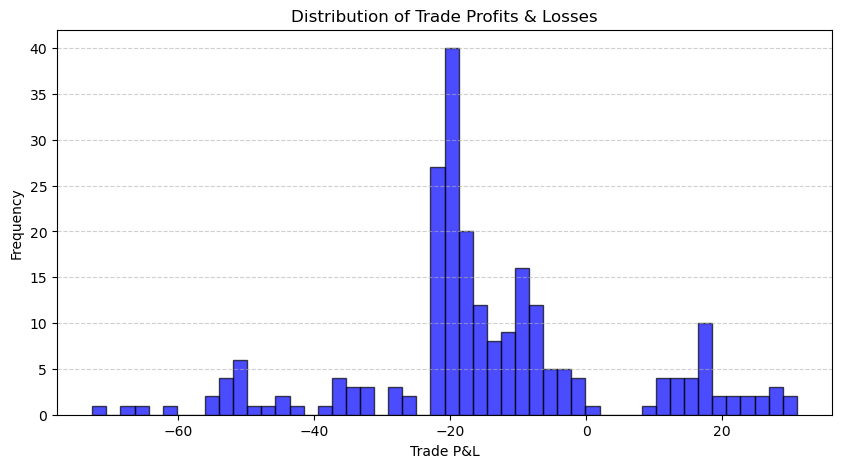

In [109]:
# plot distribution of profits per trades

closed_trades = [trade for trade in e.strategy.trades if trade.role in ['exit', 'cover']]

pnl_list = [trade.pnl for trade in closed_trades]

plt.figure(figsize=(10, 5))
plt.hist(pnl_list, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Trade P&L")
plt.ylabel("Frequency")
plt.title("Distribution of Trade Profits & Losses")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [110]:
closed_trades

[<Trade: 2025-03-01 02:00:00 btc sell 0.01198281@84656.93 Role:exit PnL:9.574385018099937>,
 <Trade: 2025-03-01 03:00:00 btc sell 0.00011417000000000024@85240.46 Role:exit PnL:0.15784459180000127>,
 <Trade: 2025-03-01 05:00:00 btc buy 0.01176967@86190.01 Role:cover PnL:-10.11214737389998>,
 <Trade: 2025-03-01 22:00:00 btc buy 0.01178514@86076.86 Role:cover PnL:-8.791950142800047>,
 <Trade: 2025-03-01 23:00:00 btc buy 0.01177974@86116.35 Role:cover PnL:-9.25310356740011>,
 <Trade: 2025-03-02 00:00:00 btc buy 0.01178683@86064.53 Role:cover PnL:-8.647879302700026>,
 <Trade: 2025-03-02 01:00:00 btc buy 0.01179202@86026.62 Role:cover PnL:-8.204651675599987>,
 <Trade: 2025-03-02 04:00:00 btc buy 0.01181311@85873.07 Role:cover PnL:-6.405422635300123>,
 <Trade: 2025-03-02 06:00:00 btc buy 0.0118015@85957.51 Role:cover PnL:-7.395646004999979>,
 <Trade: 2025-03-02 07:00:00 btc buy 0.01175771@86277.65 Role:cover PnL:-11.132317405099972>,
 <Trade: 2025-03-02 08:00:00 btc buy 0.01176388@86232.42 Ro

In [111]:
time_label = [trade.idx for trade in closed_trades]
time_label

[Timestamp('2025-03-01 02:00:00'),
 Timestamp('2025-03-01 03:00:00'),
 Timestamp('2025-03-01 05:00:00'),
 Timestamp('2025-03-01 22:00:00'),
 Timestamp('2025-03-01 23:00:00'),
 Timestamp('2025-03-02 00:00:00'),
 Timestamp('2025-03-02 01:00:00'),
 Timestamp('2025-03-02 04:00:00'),
 Timestamp('2025-03-02 06:00:00'),
 Timestamp('2025-03-02 07:00:00'),
 Timestamp('2025-03-02 08:00:00'),
 Timestamp('2025-03-02 10:00:00'),
 Timestamp('2025-03-02 11:00:00'),
 Timestamp('2025-03-02 12:00:00'),
 Timestamp('2025-03-02 13:00:00'),
 Timestamp('2025-03-03 15:00:00'),
 Timestamp('2025-03-03 16:00:00'),
 Timestamp('2025-03-03 17:00:00'),
 Timestamp('2025-03-03 18:00:00'),
 Timestamp('2025-03-03 19:00:00'),
 Timestamp('2025-03-03 20:00:00'),
 Timestamp('2025-03-03 21:00:00'),
 Timestamp('2025-03-03 23:00:00'),
 Timestamp('2025-03-04 00:00:00'),
 Timestamp('2025-03-04 01:00:00'),
 Timestamp('2025-03-04 02:00:00'),
 Timestamp('2025-03-04 03:00:00'),
 Timestamp('2025-03-04 04:00:00'),
 Timestamp('2025-03-

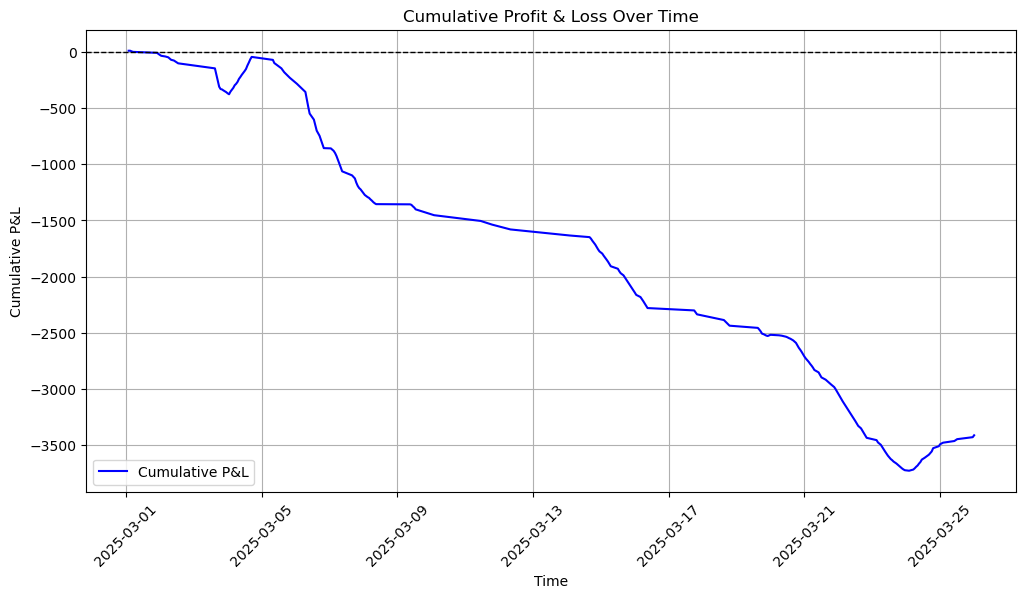

In [112]:
time_label_series = pd.Series(time_label)

# Compute cumulative P&L
cumulative_pnl = np.cumsum(pnl_list)

# Create a DataFrame to align P&L with time labels
pnl_df = pd.DataFrame({'time': time_label_series, 'cumulative_pnl': cumulative_pnl})
pnl_df.set_index('time', inplace=True)  # Set time as index

# Sort by time in case it's out of order
pnl_df.sort_index(inplace=True)

# Plot cumulative P&L over time
plt.figure(figsize=(12, 6))
plt.plot(pnl_df.index, pnl_df['cumulative_pnl'], label="Cumulative P&L", color="blue")
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Baseline at 0
plt.xlabel("Time")
plt.ylabel("Cumulative P&L")
plt.title("Cumulative Profit & Loss Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()
plt.show()

In [113]:
e.strategy.get_position('btc')

<Position: btc size: 0.6995628599999997 entry: 85943.28>

In [114]:
e.strategy.get_position('btc').size * e.strategy.close()

np.float64(61430.83235086617)

In [115]:
# Define the parameter ranges
initial_cash_values = range(100_000, 750_000, 50_000)  # 100k to 700k in 50k steps
transaction_cost_values = [i/10000 for i in range(10, 101,10)]  # 0.001 to 0.01 (0.1% to 1%)

# Initialize results storage
results = []

# Run backtests for all combinations
for initial_cash in tqdm(initial_cash_values, desc="Initial Cash"):
    row = {}
    for transaction_cost in tqdm(transaction_cost_values, desc=f"Transaction Costs for ${initial_cash:,}", leave=False):
        # Create and run engine
        e = Engine(
            initial_cash=initial_cash,
            transaction_cost=transaction_cost,
            asset_type='cryptocurrencies'
        )
        e.add_data(test_frame)
        e.add_strategy(XGBoostStrategy(
            model=loaded_final_model,
            bet_size=best_params["bet_size"],
            initial_data=initial_test_frame,  # Pass initial data for sequencing
        ))

        stats = e.run()
        
        # Store results
        key = f"{transaction_cost*100:.2f}%"
        row[key] = (
            round(stats['Strategy Sharpe Ratio'], 2),
            round(stats['Buy & Hold Sharpe Ratio'], 2)
        )
    results.append(row)

# Convert results to DataFrame
df_results = pd.DataFrame(
    results,
    index=[f"${x:,}" for x in initial_cash_values]
)

# Display the results table
print("Sharpe Ratios (Strategy, Buy & Hold) for different parameters:")
print(df_results)


Initial Cash:   0%|          | 0/13 [00:00<?, ?it/s]













100%|██████████| 613/613 [00:01<00:00, 441.08it/s]


Final Portfolio Value: 106229.70593897981
Initial Portfolio Value: 100000
Buy & Hold Final Value: 103897.68086755012
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)     













100%|██████████| 613/613 [00:01<00:00, 487.63it/s]


Final Portfolio Value: 105651.0060909475
Initial Portfolio Value: 100000
Buy & Hold Final Value: 103689.78160823825
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)      














100%|██████████| 613/613 [00:01<00:00, 431.41it/s]


Final Portfolio Value: 105119.36152784099
Initial Portfolio Value: 100000
Buy & Hold Final Value: 103482.09056050306
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)     














100%|██████████| 613/613 [00:01<00:00, 482.86it/s]


Final Portfolio Value: 104591.85907047786
Initial Portfolio Value: 100000
Buy & Hold Final Value: 103274.60772434456
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)     














100%|██████████| 613/613 [00:01<00:00, 465.35it/s]


Final Portfolio Value: 104017.21693262988
Initial Portfolio Value: 100000
Buy & Hold Final Value: 103067.33309976272
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)     













100%|██████████| 613/613 [00:01<00:00, 496.84it/s]


Final Portfolio Value: 103489.6055539138
Initial Portfolio Value: 100000
Buy & Hold Final Value: 102860.26668675756
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      














100%|██████████| 613/613 [00:01<00:00, 467.52it/s]


Final Portfolio Value: 102963.11752474227
Initial Portfolio Value: 100000
Buy & Hold Final Value: 102653.4084853291
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      














100%|██████████| 613/613 [00:01<00:00, 423.45it/s]


Final Portfolio Value: 102392.53309769309
Initial Portfolio Value: 100000
Buy & Hold Final Value: 102446.75849547728
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)     













100%|██████████| 613/613 [00:01<00:00, 482.00it/s]


Final Portfolio Value: 101867.05949605715
Initial Portfolio Value: 100000
Buy & Hold Final Value: 102240.31671720216
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)     













Initial Cash:   8%|▊         | 1/13 [00:13<02:39, 13.32s/it]

Final Portfolio Value: 101334.62632018293
Initial Portfolio Value: 100000
Buy & Hold Final Value: 102034.08315050372
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)     














100%|██████████| 613/613 [00:01<00:00, 450.49it/s]


Final Portfolio Value: 159344.55871913463
Initial Portfolio Value: 150000
Buy & Hold Final Value: 155846.52130132518
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)     














100%|██████████| 613/613 [00:01<00:00, 471.48it/s]


Final Portfolio Value: 158476.50893483756
Initial Portfolio Value: 150000
Buy & Hold Final Value: 155534.67241235738
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)     














100%|██████████| 613/613 [00:01<00:00, 463.51it/s]


Final Portfolio Value: 157679.04211924286
Initial Portfolio Value: 150000
Buy & Hold Final Value: 155223.1358407546
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)      













100%|██████████| 613/613 [00:01<00:00, 479.01it/s]


Final Portfolio Value: 156887.78844160613
Initial Portfolio Value: 150000
Buy & Hold Final Value: 154911.91158651683
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)     














100%|██████████| 613/613 [00:01<00:00, 474.36it/s]


Final Portfolio Value: 156025.82522383798
Initial Portfolio Value: 150000
Buy & Hold Final Value: 154600.9996496441
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      














100%|██████████| 613/613 [00:01<00:00, 466.41it/s]


Final Portfolio Value: 155234.40820300515
Initial Portfolio Value: 150000
Buy & Hold Final Value: 154290.40003013637
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)     














100%|██████████| 613/613 [00:01<00:00, 469.67it/s]


Final Portfolio Value: 154444.67616723882
Initial Portfolio Value: 150000
Buy & Hold Final Value: 153980.11272799363
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)     















100%|██████████| 613/613 [00:01<00:00, 416.34it/s]


Final Portfolio Value: 153588.79951650463
Initial Portfolio Value: 150000
Buy & Hold Final Value: 153670.13774321595
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)     















100%|██████████| 613/613 [00:01<00:00, 428.03it/s]


Final Portfolio Value: 152800.58912245923
Initial Portfolio Value: 150000
Buy & Hold Final Value: 153360.47507580326
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)     
















Initial Cash:  15%|█▌        | 2/13 [00:27<02:29, 13.57s/it]

Final Portfolio Value: 152001.9394044233
Initial Portfolio Value: 150000
Buy & Hold Final Value: 153051.12472575557
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)      
















100%|██████████| 613/613 [00:01<00:00, 395.76it/s]


Final Portfolio Value: 212459.41096109734
Initial Portfolio Value: 200000
Buy & Hold Final Value: 207795.36173510025
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)     
















100%|██████████| 613/613 [00:01<00:00, 402.70it/s]


Final Portfolio Value: 211302.01123679976
Initial Portfolio Value: 200000
Buy & Hold Final Value: 207379.5632164765
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)      

















100%|██████████| 613/613 [00:01<00:00, 375.03it/s]


Final Portfolio Value: 210238.72212126257
Initial Portfolio Value: 200000
Buy & Hold Final Value: 206964.1811210061
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)      















100%|██████████| 613/613 [00:01<00:00, 416.53it/s]


Final Portfolio Value: 209183.71722044973
Initial Portfolio Value: 200000
Buy & Hold Final Value: 206549.21544868912
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)     

















100%|██████████| 613/613 [00:01<00:00, 374.39it/s]


Final Portfolio Value: 208034.43291985797
Initial Portfolio Value: 200000
Buy & Hold Final Value: 206134.66619952544
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)     















100%|██████████| 613/613 [00:01<00:00, 418.57it/s]


Final Portfolio Value: 206979.2102540049
Initial Portfolio Value: 200000
Buy & Hold Final Value: 205720.53337351512
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      
















100%|██████████| 613/613 [00:01<00:00, 391.79it/s]


Final Portfolio Value: 205926.2342087404
Initial Portfolio Value: 200000
Buy & Hold Final Value: 205306.8169706582
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       
















100%|██████████| 613/613 [00:01<00:00, 414.66it/s]


Final Portfolio Value: 204785.0653314177
Initial Portfolio Value: 200000
Buy & Hold Final Value: 204893.51699095455
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)      
















100%|██████████| 613/613 [00:01<00:00, 388.39it/s]


Final Portfolio Value: 203734.11814205977
Initial Portfolio Value: 200000
Buy & Hold Final Value: 204480.63343440433
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)     
















Initial Cash:  23%|██▎       | 3/13 [00:42<02:24, 14.47s/it]

Final Portfolio Value: 202669.251878959
Initial Portfolio Value: 200000
Buy & Hold Final Value: 204068.16630100744
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       
















100%|██████████| 613/613 [00:01<00:00, 412.38it/s]


Final Portfolio Value: 265574.2641798111
Initial Portfolio Value: 250000
Buy & Hold Final Value: 259744.20216887526
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)      















100%|██████████| 613/613 [00:01<00:00, 430.62it/s]


Final Portfolio Value: 264127.51453898964
Initial Portfolio Value: 250000
Buy & Hold Final Value: 259224.45402059561
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)     

















100%|██████████| 613/613 [00:01<00:00, 381.47it/s]


Final Portfolio Value: 262798.403108078
Initial Portfolio Value: 250000
Buy & Hold Final Value: 258705.22640125765
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       
















100%|██████████| 613/613 [00:01<00:00, 397.52it/s]


Final Portfolio Value: 261479.64696541865
Initial Portfolio Value: 250000
Buy & Hold Final Value: 258186.5193108614
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)      
















100%|██████████| 613/613 [00:01<00:00, 396.99it/s]


Final Portfolio Value: 260043.0416021431
Initial Portfolio Value: 250000
Buy & Hold Final Value: 257668.33274940684
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      















100%|██████████| 613/613 [00:01<00:00, 422.64it/s]


Final Portfolio Value: 258724.0132337917
Initial Portfolio Value: 250000
Buy & Hold Final Value: 257150.6667168939
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       
















100%|██████████| 613/613 [00:01<00:00, 385.62it/s]


Final Portfolio Value: 257407.7931603599
Initial Portfolio Value: 250000
Buy & Hold Final Value: 256633.5212133227
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       

















100%|██████████| 613/613 [00:01<00:00, 370.76it/s]


Final Portfolio Value: 255981.3320740824
Initial Portfolio Value: 250000
Buy & Hold Final Value: 256116.89623869324
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)      















100%|██████████| 613/613 [00:01<00:00, 416.09it/s]


Final Portfolio Value: 254667.6480699072
Initial Portfolio Value: 250000
Buy & Hold Final Value: 255600.79179300542
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)      
















Initial Cash:  31%|███       | 4/13 [00:58<02:13, 14.89s/it]

Final Portfolio Value: 253336.5651675033
Initial Portfolio Value: 250000
Buy & Hold Final Value: 255085.2078762593
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       















100%|██████████| 613/613 [00:01<00:00, 425.37it/s]


Final Portfolio Value: 318689.1170889698
Initial Portfolio Value: 300000
Buy & Hold Final Value: 311693.04260265036
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)      

















100%|██████████| 613/613 [00:01<00:00, 374.97it/s]


Final Portfolio Value: 316953.0175139846
Initial Portfolio Value: 300000
Buy & Hold Final Value: 311069.34482471476
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)      















100%|██████████| 613/613 [00:01<00:00, 419.08it/s]


Final Portfolio Value: 315358.0838326843
Initial Portfolio Value: 300000
Buy & Hold Final Value: 310446.2716815092
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       

















100%|██████████| 613/613 [00:01<00:00, 371.87it/s]


Final Portfolio Value: 313775.5764718516
Initial Portfolio Value: 300000
Buy & Hold Final Value: 309823.82317303366
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)      
















100%|██████████| 613/613 [00:01<00:00, 417.16it/s]


Final Portfolio Value: 312051.65003075614
Initial Portfolio Value: 300000
Buy & Hold Final Value: 309201.9992992882
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      
















100%|██████████| 613/613 [00:01<00:00, 387.40it/s]


Final Portfolio Value: 310468.8159835306
Initial Portfolio Value: 300000
Buy & Hold Final Value: 308580.80006027274
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      
















100%|██████████| 613/613 [00:01<00:00, 393.68it/s]


Final Portfolio Value: 308889.3519064387
Initial Portfolio Value: 300000
Buy & Hold Final Value: 307960.22545598727
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      

















100%|██████████| 613/613 [00:01<00:00, 382.12it/s]


Final Portfolio Value: 307177.598599411
Initial Portfolio Value: 300000
Buy & Hold Final Value: 307340.2754864319
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)        
















100%|██████████| 613/613 [00:01<00:00, 371.57it/s]


Final Portfolio Value: 305601.1778057609
Initial Portfolio Value: 300000
Buy & Hold Final Value: 306720.9501516065
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       
















Initial Cash:  38%|███▊      | 5/13 [01:13<02:01, 15.21s/it]

Final Portfolio Value: 304003.8783641297
Initial Portfolio Value: 300000
Buy & Hold Final Value: 306102.24945151113
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)      

















100%|██████████| 613/613 [00:01<00:00, 377.78it/s]


Final Portfolio Value: 371803.97070038726
Initial Portfolio Value: 350000
Buy & Hold Final Value: 363641.8830364254
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)      

















100%|██████████| 613/613 [00:01<00:00, 371.15it/s]


Final Portfolio Value: 369778.52117599675
Initial Portfolio Value: 350000
Buy & Hold Final Value: 362914.2356288339
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)      



















100%|██████████| 613/613 [00:02<00:00, 300.88it/s]


Final Portfolio Value: 367917.76522906835
Initial Portfolio Value: 350000
Buy & Hold Final Value: 362187.31696176075
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)     

















100%|██████████| 613/613 [00:01<00:00, 369.74it/s]


Final Portfolio Value: 366071.50663482264
Initial Portfolio Value: 350000
Buy & Hold Final Value: 361461.12703520595
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)     

















100%|██████████| 613/613 [00:01<00:00, 374.02it/s]


Final Portfolio Value: 364060.2591006671
Initial Portfolio Value: 350000
Buy & Hold Final Value: 360735.6658491695
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       

















100%|██████████| 613/613 [00:01<00:00, 363.90it/s]


Final Portfolio Value: 362213.61939818424
Initial Portfolio Value: 350000
Buy & Hold Final Value: 360010.9334036515
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      

















100%|██████████| 613/613 [00:01<00:00, 374.62it/s]


Final Portfolio Value: 360370.9113013576
Initial Portfolio Value: 350000
Buy & Hold Final Value: 359286.9296986519
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       


















100%|██████████| 613/613 [00:01<00:00, 362.67it/s]


Final Portfolio Value: 358373.86575750425
Initial Portfolio Value: 350000
Buy & Hold Final Value: 358563.6547341705
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)      



















100%|██████████| 613/613 [00:01<00:00, 313.24it/s]


Final Portfolio Value: 356534.70815830573
Initial Portfolio Value: 350000
Buy & Hold Final Value: 357841.10851020756
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)     


















Initial Cash:  46%|████▌     | 6/13 [01:31<01:52, 16.01s/it]

Final Portfolio Value: 354671.19212127116
Initial Portfolio Value: 350000
Buy & Hold Final Value: 357119.291026763
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       
















100%|██████████| 613/613 [00:01<00:00, 386.28it/s]


Final Portfolio Value: 424918.823181937
Initial Portfolio Value: 400000
Buy & Hold Final Value: 415590.7234702005
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)        















100%|██████████| 613/613 [00:01<00:00, 423.70it/s]


Final Portfolio Value: 422604.0237550504
Initial Portfolio Value: 400000
Buy & Hold Final Value: 414759.126432953
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)        

















100%|██████████| 613/613 [00:01<00:00, 352.85it/s]


Final Portfolio Value: 420477.44550677517
Initial Portfolio Value: 400000
Buy & Hold Final Value: 413928.3622420122
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)      
















100%|██████████| 613/613 [00:01<00:00, 404.74it/s]


Final Portfolio Value: 418367.435684712
Initial Portfolio Value: 400000
Buy & Hold Final Value: 413098.43089737825
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       
















100%|██████████| 613/613 [00:01<00:00, 402.63it/s]


Final Portfolio Value: 416068.8671019004
Initial Portfolio Value: 400000
Buy & Hold Final Value: 412269.3323990509
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       















100%|██████████| 613/613 [00:01<00:00, 408.26it/s]


Final Portfolio Value: 413958.4217109483
Initial Portfolio Value: 400000
Buy & Hold Final Value: 411441.06674703024
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      


















100%|██████████| 613/613 [00:01<00:00, 350.23it/s]


Final Portfolio Value: 411852.46959998226
Initial Portfolio Value: 400000
Buy & Hold Final Value: 410613.6339413164
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      















100%|██████████| 613/613 [00:01<00:00, 412.44it/s]


Final Portfolio Value: 409570.13186120277
Initial Portfolio Value: 400000
Buy & Hold Final Value: 409787.0339819091
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)      
















100%|██████████| 613/613 [00:01<00:00, 409.85it/s]


Final Portfolio Value: 407468.23746121477
Initial Portfolio Value: 400000
Buy & Hold Final Value: 408961.26686880866
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)     

















Initial Cash:  54%|█████▍    | 7/13 [01:47<01:35, 16.00s/it]

Final Portfolio Value: 405338.5048390068
Initial Portfolio Value: 400000
Buy & Hold Final Value: 408136.3326020149
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       

















100%|██████████| 613/613 [00:01<00:00, 382.47it/s]


Final Portfolio Value: 478033.67564307037
Initial Portfolio Value: 450000
Buy & Hold Final Value: 467539.5639039754
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)      















100%|██████████| 613/613 [00:01<00:00, 422.77it/s]


Final Portfolio Value: 475429.52629410964
Initial Portfolio Value: 450000
Buy & Hold Final Value: 466604.0172370721
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)      
















100%|██████████| 613/613 [00:01<00:00, 392.00it/s]


Final Portfolio Value: 473037.12580753723
Initial Portfolio Value: 450000
Buy & Hold Final Value: 465669.40752226376
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)     
















100%|██████████| 613/613 [00:01<00:00, 416.31it/s]


Final Portfolio Value: 470663.3647793917
Initial Portfolio Value: 450000
Buy & Hold Final Value: 464735.7347595505
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       

















100%|██████████| 613/613 [00:01<00:00, 383.33it/s]


Final Portfolio Value: 468077.4751308497
Initial Portfolio Value: 450000
Buy & Hold Final Value: 463802.9989489322
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       















100%|██████████| 613/613 [00:01<00:00, 422.13it/s]


Final Portfolio Value: 465703.2241119711
Initial Portfolio Value: 450000
Buy & Hold Final Value: 462871.200090409
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)        
















100%|██████████| 613/613 [00:01<00:00, 377.82it/s]


Final Portfolio Value: 463334.0280086013
Initial Portfolio Value: 450000
Buy & Hold Final Value: 461940.3381839809
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       

















100%|██████████| 613/613 [00:01<00:00, 385.65it/s]


Final Portfolio Value: 460766.39806032623
Initial Portfolio Value: 450000
Buy & Hold Final Value: 461010.41322964785
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)     


















100%|██████████| 613/613 [00:01<00:00, 360.67it/s]


Final Portfolio Value: 458401.76688212
Initial Portfolio Value: 450000
Buy & Hold Final Value: 460081.4252274097
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)         















Initial Cash:  62%|██████▏   | 8/13 [02:03<01:19, 15.90s/it]

Final Portfolio Value: 456005.8177319409
Initial Portfolio Value: 450000
Buy & Hold Final Value: 459153.3741772667
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       
















100%|██████████| 613/613 [00:01<00:00, 405.19it/s]


Final Portfolio Value: 531148.5284982412
Initial Portfolio Value: 500000
Buy & Hold Final Value: 519488.4043377505
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)       

















100%|██████████| 613/613 [00:01<00:00, 372.17it/s]


Final Portfolio Value: 528255.0291879963
Initial Portfolio Value: 500000
Buy & Hold Final Value: 518448.90804119123
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)      

















100%|██████████| 613/613 [00:01<00:00, 379.92it/s]


Final Portfolio Value: 525596.8064239174
Initial Portfolio Value: 500000
Buy & Hold Final Value: 517410.4528025153
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       

















100%|██████████| 613/613 [00:01<00:00, 378.44it/s]


Final Portfolio Value: 522959.2941504776
Initial Portfolio Value: 500000
Buy & Hold Final Value: 516373.0386217228
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       

















100%|██████████| 613/613 [00:01<00:00, 371.24it/s]


Final Portfolio Value: 520086.08339699754
Initial Portfolio Value: 500000
Buy & Hold Final Value: 515336.6654988137
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      


















100%|██████████| 613/613 [00:01<00:00, 351.17it/s]


Final Portfolio Value: 517448.02667212463
Initial Portfolio Value: 500000
Buy & Hold Final Value: 514301.3334337878
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      

















100%|██████████| 613/613 [00:01<00:00, 355.64it/s]


Final Portfolio Value: 514815.58653797477
Initial Portfolio Value: 500000
Buy & Hold Final Value: 513267.0424266454
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)      

















100%|██████████| 613/613 [00:01<00:00, 374.09it/s]


Final Portfolio Value: 511962.6643418313
Initial Portfolio Value: 500000
Buy & Hold Final Value: 512233.7924773865
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       


















100%|██████████| 613/613 [00:01<00:00, 369.35it/s]


Final Portfolio Value: 509335.29634703
Initial Portfolio Value: 500000
Buy & Hold Final Value: 511201.58358601085
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)        

















Initial Cash:  69%|██████▉   | 9/13 [02:19<01:04, 16.15s/it]

Final Portfolio Value: 506673.13059040345
Initial Portfolio Value: 500000
Buy & Hold Final Value: 510170.4157525186
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)      
















100%|██████████| 613/613 [00:01<00:00, 405.75it/s]


Final Portfolio Value: 584263.3818458831
Initial Portfolio Value: 550000
Buy & Hold Final Value: 571437.2447715256
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)       
















100%|██████████| 613/613 [00:01<00:00, 400.02it/s]


Final Portfolio Value: 581080.5326426595
Initial Portfolio Value: 550000
Buy & Hold Final Value: 570293.7988453103
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       















100%|██████████| 613/613 [00:01<00:00, 432.81it/s]


Final Portfolio Value: 578156.487586752
Initial Portfolio Value: 550000
Buy & Hold Final Value: 569151.4980827669
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)        
















100%|██████████| 613/613 [00:01<00:00, 400.26it/s]


Final Portfolio Value: 575255.2240950145
Initial Portfolio Value: 550000
Buy & Hold Final Value: 568010.3424838951
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       















100%|██████████| 613/613 [00:01<00:00, 422.27it/s]


Final Portfolio Value: 572094.6923023964
Initial Portfolio Value: 550000
Buy & Hold Final Value: 566870.332048695
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)        
















100%|██████████| 613/613 [00:01<00:00, 383.37it/s]


Final Portfolio Value: 569192.8298985723
Initial Portfolio Value: 550000
Buy & Hold Final Value: 565731.4667771666
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       
















100%|██████████| 613/613 [00:01<00:00, 394.02it/s]


Final Portfolio Value: 566297.1457598003
Initial Portfolio Value: 550000
Buy & Hold Final Value: 564593.74666931
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)         
















100%|██████████| 613/613 [00:01<00:00, 415.62it/s]


Final Portfolio Value: 563158.9313782479
Initial Portfolio Value: 550000
Buy & Hold Final Value: 563457.171725125
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)        















100%|██████████| 613/613 [00:01<00:00, 443.02it/s]


Final Portfolio Value: 560268.8265921777
Initial Portfolio Value: 550000
Buy & Hold Final Value: 562321.7419446119
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       















Initial Cash:  77%|███████▋  | 10/13 [02:34<00:47, 15.81s/it]

Final Portfolio Value: 557340.4442598942
Initial Portfolio Value: 550000
Buy & Hold Final Value: 561187.4573277705
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       

















100%|██████████| 613/613 [00:01<00:00, 361.66it/s]


Final Portfolio Value: 637378.2341759612
Initial Portfolio Value: 600000
Buy & Hold Final Value: 623386.0852053007
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)       
















100%|██████████| 613/613 [00:01<00:00, 390.41it/s]


Final Portfolio Value: 633906.035021874
Initial Portfolio Value: 600000
Buy & Hold Final Value: 622138.6896494295
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)        
















100%|██████████| 613/613 [00:01<00:00, 411.39it/s]


Final Portfolio Value: 630716.167655158
Initial Portfolio Value: 600000
Buy & Hold Final Value: 620892.5433630184
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)        
















100%|██████████| 613/613 [00:01<00:00, 422.14it/s]


Final Portfolio Value: 627551.1529293773
Initial Portfolio Value: 600000
Buy & Hold Final Value: 619647.6463460673
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       














100%|██████████| 613/613 [00:01<00:00, 456.60it/s]


Final Portfolio Value: 624103.3000430691
Initial Portfolio Value: 600000
Buy & Hold Final Value: 618403.9985985764
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       















100%|██████████| 613/613 [00:01<00:00, 450.33it/s]


Final Portfolio Value: 620937.6319833599
Initial Portfolio Value: 600000
Buy & Hold Final Value: 617161.6001205455
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       















100%|██████████| 613/613 [00:01<00:00, 424.61it/s]


Final Portfolio Value: 617778.7038242246
Initial Portfolio Value: 600000
Buy & Hold Final Value: 615920.4509119745
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       















100%|██████████| 613/613 [00:01<00:00, 407.22it/s]


Final Portfolio Value: 614355.197205219
Initial Portfolio Value: 600000
Buy & Hold Final Value: 614680.5509728638
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)        














100%|██████████| 613/613 [00:01<00:00, 435.57it/s]


Final Portfolio Value: 611202.3556129679
Initial Portfolio Value: 600000
Buy & Hold Final Value: 613441.900303213
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)        














Initial Cash:  85%|████████▍ | 11/13 [02:49<00:31, 15.50s/it]

Final Portfolio Value: 608007.7567247552
Initial Portfolio Value: 600000
Buy & Hold Final Value: 612204.4989030223
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       















100%|██████████| 613/613 [00:01<00:00, 409.05it/s]


Final Portfolio Value: 690493.0879142587
Initial Portfolio Value: 650000
Buy & Hold Final Value: 675334.9256390756
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)       














100%|██████████| 613/613 [00:01<00:00, 483.27it/s]


Final Portfolio Value: 686731.5388028352
Initial Portfolio Value: 650000
Buy & Hold Final Value: 673983.5804535486
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       













100%|██████████| 613/613 [00:01<00:00, 502.27it/s]


Final Portfolio Value: 683275.8491625612
Initial Portfolio Value: 650000
Buy & Hold Final Value: 672633.58864327
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)         













100%|██████████| 613/613 [00:01<00:00, 501.94it/s]


Final Portfolio Value: 679847.0831954386
Initial Portfolio Value: 650000
Buy & Hold Final Value: 671284.9502082396
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       













100%|██████████| 613/613 [00:01<00:00, 509.00it/s]


Final Portfolio Value: 676111.909208142
Initial Portfolio Value: 650000
Buy & Hold Final Value: 669937.6651484576
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)        













100%|██████████| 613/613 [00:01<00:00, 492.76it/s]


Final Portfolio Value: 672682.4354852461
Initial Portfolio Value: 650000
Buy & Hold Final Value: 668591.7334639243
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       













100%|██████████| 613/613 [00:01<00:00, 480.35it/s]


Final Portfolio Value: 669260.2632984474
Initial Portfolio Value: 650000
Buy & Hold Final Value: 667247.155154639
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)        















100%|██████████| 613/613 [00:01<00:00, 422.83it/s]


Final Portfolio Value: 665551.4644346863
Initial Portfolio Value: 650000
Buy & Hold Final Value: 665903.9302206023
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       














100%|██████████| 613/613 [00:01<00:00, 445.55it/s]


Final Portfolio Value: 662135.8860289571
Initial Portfolio Value: 650000
Buy & Hold Final Value: 664562.0586618141
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)       















Initial Cash:  92%|█████████▏| 12/13 [03:02<00:14, 14.84s/it]

Final Portfolio Value: 658675.070537413
Initial Portfolio Value: 650000
Buy & Hold Final Value: 663221.5404782741
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)        















100%|██████████| 613/613 [00:01<00:00, 400.02it/s]


Final Portfolio Value: 743607.9398893532
Initial Portfolio Value: 700000
Buy & Hold Final Value: 727283.7660728508
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.23
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.70
Strategy CAGR (%)                        |     141.65
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.53
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     521.00
Number of Buys                           |     287.00
Number of Sells                          |     234.00
Win Rate (%)       














100%|██████████| 613/613 [00:01<00:00, 486.99it/s]


Final Portfolio Value: 739557.0408864508
Initial Portfolio Value: 700000
Buy & Hold Final Value: 725828.4712576678
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.65
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     123.13
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.56
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       














100%|██████████| 613/613 [00:01<00:00, 479.96it/s]


Final Portfolio Value: 735835.5289558447
Initial Portfolio Value: 700000
Buy & Hold Final Value: 724374.6339235215
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.12
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.52
Strategy CAGR (%)                        |     107.28
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      16.96
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.55
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       













100%|██████████| 613/613 [00:01<00:00, 490.11it/s]


Final Portfolio Value: 732143.0117719187
Initial Portfolio Value: 700000
Buy & Hold Final Value: 722922.2540704119
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.59
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.69
Strategy CAGR (%)                        |      92.61
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.58
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     520.00
Number of Buys                           |     286.00
Number of Sells                          |     234.00
Win Rate (%)       














100%|██████████| 613/613 [00:01<00:00, 495.20it/s]


Final Portfolio Value: 728120.516746981
Initial Portfolio Value: 700000
Buy & Hold Final Value: 721471.331698339
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.02
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      77.72
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.26
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)         














100%|██████████| 613/613 [00:01<00:00, 493.34it/s]


Final Portfolio Value: 724427.2373077717
Initial Portfolio Value: 700000
Buy & Hold Final Value: 720021.866807303
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.49
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.50
Strategy CAGR (%)                        |      65.00
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.25
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)        













100%|██████████| 613/613 [00:01<00:00, 527.74it/s]


Final Portfolio Value: 720741.8211186836
Initial Portfolio Value: 700000
Buy & Hold Final Value: 718573.8593973038
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.67
Strategy CAGR (%)                        |      53.16
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.36
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     519.00
Number of Buys                           |     285.00
Number of Sells                          |     234.00
Win Rate (%)       













100%|██████████| 613/613 [00:01<00:00, 519.48it/s]


Final Portfolio Value: 716747.7300718449
Initial Portfolio Value: 700000
Buy & Hold Final Value: 717127.309468341
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.39
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.48
Strategy CAGR (%)                        |      41.23
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.49
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.66
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)        













100%|██████████| 613/613 [00:01<00:00, 503.35it/s]


Final Portfolio Value: 713069.414877177
Initial Portfolio Value: 700000
Buy & Hold Final Value: 715682.2170204151
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.87
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      31.01
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.87
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.69
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)        













Initial Cash: 100%|██████████| 13/13 [03:15<00:00, 15.05s/it]

Final Portfolio Value: 709342.3828123056
Initial Portfolio Value: 700000
Buy & Hold Final Value: 714238.582053526
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.33
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      44.64
Strategy CAGR (%)                        |      21.36
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.77
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |     518.00
Number of Buys                           |     284.00
Number of Sells                          |     234.00
Win Rate (%)        

In [116]:
transaction_cost_values

[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

In [117]:
df_results

,0.10%,0.20%,0.30%,0.40%,0.50%,0.60%,0.70%,0.80%,0.90%,1.00%
"$100,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$150,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$200,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$250,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$300,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$350,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$400,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$450,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$500,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$550,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"


In [118]:
df_results = df_results.map(lambda x: (float(x[0]), float(x[1])))
def color_cells(val):
    strategy, buy_hold = val
    if strategy > buy_hold:
        return 'background-color: green; color: white'
    else:
        return 'background-color: red; color: white'
    
styled_table = df_results.style.map(color_cells)
styled_table    

,0.10%,0.20%,0.30%,0.40%,0.50%,0.60%,0.70%,0.80%,0.90%,1.00%
"$100,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$150,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$200,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$250,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$300,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$350,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$400,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$450,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$500,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
"$550,000","(22.37, 6.95)","(19.47, 6.95)","(16.96, 6.95)","(14.6, 6.95)","(12.26, 6.95)","(10.25, 6.95)","(8.36, 6.95)","(6.49, 6.95)","(4.87, 6.95)","(3.35, 6.95)"
